# Notebook for the Project

## Introduction

Do MNIST-1D, compare CNN, RandomForest with PCA, LinearRegression with PCA

Goal: Compare the relation of accuracy to training and prediction time.
Expected outcome: CNN is the most accurate, but will be a lot slower than the others.

## Dependencies

In [1]:
# !pip install torch
# !pip install pandas
# !pip install scikit-learn
# !pip install tensorboard
# !pip install seaborn
# !pip install torchvision

## Imports

In [16]:
import torch
from torch import autograd
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
from copy import deepcopy

from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter
import sklearn.metrics as metrics
from pandas import Series
from typing import Union
import json
from sklearn.metrics import confusion_matrix, accuracy_score


## Helper functions

In [6]:

def train(train_loader, model, optimizer, criterion, device, detect_bad_gradients=False, clip_grad_norm=False):
    """
    Trains PyTorch modelfor one epoch in batches.

    Args:
        train_loader: Data loader for training set.
        model: Neural network model.
        optimizer: Optimizer (e.g. SGD).
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0

    model.train()

    # Iterate through batches
    for i, data in enumerate(train_loader):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move data to target device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Compute RMSE from MSE
        if detect_bad_gradients:
            with autograd.detect_anomaly():
                loss.backward()
        else:
            loss.backward()
        if clip_grad_norm:
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)  # Clip gradients
        optimizer.step()

        # Keep track of loss (MSE) and r2
        avg_loss += torch.sqrt(loss)

    return avg_loss / len(train_loader)


def test(test_loader, model, criterion, device):
    """
    Evaluates network in batches.

    Args:
        test_loader: Data loader for test set.
        model: Neural network model.
        criterion: Loss function (e.g. cross-entropy loss).
    """

    avg_loss = 0

    model.eval()

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():

        # Iterate through batches
        all_predictions = []
        all_labels = []

        for data in test_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move data to target device
            inputs, labels = inputs.to(device), labels.to(device)

            if "init_hidden" in dir(model):
                previous_turbidity = inputs[:, :, model.prev_turbidity_idx]
                model.init_hidden(inputs.size(0), previous_turbidity)
            # Forward pass
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, labels))  # Compute RMSE from MSE

            all_predictions.extend(outputs.detach().numpy())
            all_labels.extend(labels.detach().numpy())

            # Keep track of loss (MSE) and r2
            avg_loss += loss

    return avg_loss / len(test_loader)
      # Track the average loss and the r2 of the last batch




def run_torch(model, train_set, val_set, test_set, log_comment="", log_hparams=False, writer=None, **config):
    """
    Run a test
    """
    try:
        if writer is None:
            # Create a writer to write to Tensorboard
            writer = SummaryWriter(comment=log_comment)
            writer.add_text("run_params", json.dumps(config, indent=2))

        # Create the dataloaders
        train_loader = DataLoader(
            train_set, batch_size=config["batch_size"], shuffle=False, num_workers=0, persistent_workers=False
        )
        val_loader = DataLoader(
            val_set, batch_size=config["batch_size"], shuffle=False, num_workers=0, persistent_workers=False
        )
        test_loader = DataLoader(
            test_set, batch_size=config["batch_size"], shuffle=False, num_workers=0, persistent_workers=False
        )

        # Create loss function and optimizer
        if config["loss"] == "MSE" or config["loss"] == "RMSE":
            criterion = nn.MSELoss()
        else:
            raise ValueError(f"Loss {config['loss']} not recognized.")

        optimizer = torch.optim.Adam(
            model.parameters(), lr=config["optimizer"]["lr"], weight_decay=config["optimizer"]["weight_decay"]
        )
        if config["lr_scheduler"]:
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, **config["lr_scheduler"])

        # Use GPU if available
        device = "cuda" if torch.cuda.is_available() else "cpu"

        model = model.to(device)

        patience = config.get("early_stopping_patience", torch.inf)
        best_model = None
        best_loss = np.inf
        counter = 0

        print("Starting initial training")
        for epoch in tqdm(range(config["epochs"])):
            # Train on data
            train_loss = train(
                train_loader, model, optimizer, criterion, device, config["detect_bad_gradients"]
            )
            # After training set eval mode on
            model.eval()
            # Test on data
            val_loss = test(val_loader, model, criterion, device)
            test_loss = test(test_loader, model, criterion, device)

            if config["lr_scheduler"]:
                scheduler.step()

            # Write metrics to Tensorboard
            writer.add_scalars("Loss", {"Train_loss": train_loss, "Val_loss": val_loss, "Test_loss": test_loss}, epoch)

            if log_hparams:

                report_metrics = {
                    "hparam/test_loss": test_loss,
                    "hparam/train_loss": train_loss,
                }
                writer.add_hparams(log_hparams, report_metrics, run_name=log_comment)

            # Early stopping
            if best_loss > val_loss.detach().numpy():
                best_loss = val_loss.detach().numpy()
                counter = 0
                best_model = deepcopy(model)
            else:
                counter += 1
                if counter > patience:
                    print("Initiating early stopping")
                    if best_model is not None:
                        print("Restoring best weights")
                        model = best_model
                    break

        print("\nTraining Finished.")
        writer.flush()
        writer.close()

        # Finally, use the model to predict the train, validation and test sets
    except KeyboardInterrupt:
        print("Interrupted")
    print("Gathering final predictions")

    if not log_hparams:
        results, predictions, model = gather_results(model, train_loader, val_loader, test_loader)

        return results, predictions, model
    else:
        return


def gather_results(model, train_loader, val_loader, test_loader):
    """
    Gather the results for train, val and test sets.
    Returns:
        results, predictions, model
    """
    model.eval()
    with torch.no_grad():

        y_train = []
        y_pred_train = []

        y_val = []
        y_pred_val = []

        y_test = []
        y_pred_test = []

        for data in train_loader:
            inputs, labels = data
            pred = model(inputs)
            y_train.extend(labels.detach().numpy().flatten())
            y_pred_train.extend(pred.detach().numpy().flatten())

        # Iterate through batches
        for data in val_loader:
            inputs, labels = data
            pred = model(inputs)
            y_val.extend(labels.detach().numpy().flatten())
            y_pred_val.extend(pred.detach().numpy().flatten())

        for data in test_loader:
            inputs, labels = data
            pred = model(inputs)
            y_test.extend(labels.detach().numpy().flatten())
            y_pred_test.extend(pred.detach().numpy().flatten())

    y_pred_train = np.array(y_pred_train)
    y_pred_val = np.array(y_pred_val)
    y_pred_test = np.array(y_pred_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    train_res = classification_report(y_train, y_pred_train)
    validation_res = classification_report(y_val, y_pred_val)
    test_res = classification_report(y_test, y_pred_test)

    results = pd.DataFrame({"train": train_res, "validate": validation_res, "test": test_res})

    predictions = {
        "train": {"y": y_train, "pred": y_pred_train},
        "validate": {"y": y_val, "pred": y_pred_val},
        "test": {"y": y_test, "pred": y_pred_test},
    }

    return results, predictions, model

## Load the data

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

train_data = MNIST('./data', train=True, download=True, transform=transform)
test_data = MNIST('./data', train=False, download=True, transform=transform)

## Study the MNIST-2D dataset

Length of the dataset

In [8]:
print("Lenght of the training set:", len(train_data))
print("Lenght of the test set:", len(test_data))
print()
print("Shape of \"features\", i.e. images: ", train_data[0][0].shape)

Lenght of the training set: 60000
Lenght of the test set: 10000

Shape of "features", i.e. images:  torch.Size([1, 28, 28])


### Show some example images

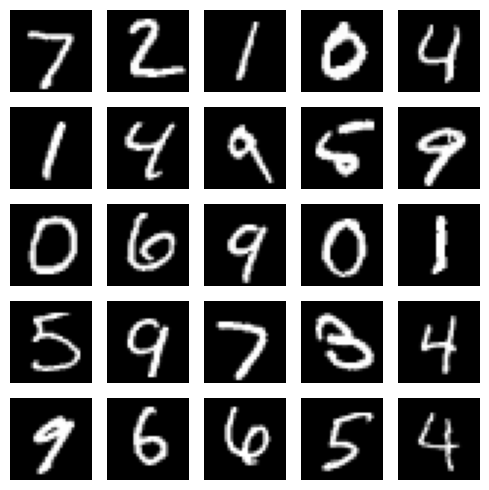

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i in range(25):
    x, _ = test_data[i]
    ax = axs[i // 5][i % 5]
    ax.imshow(x.view(28, 28), cmap='gray')
    ax.axis('off')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Distribution of labels in train and test sets

train_labels = [train_data[i][1] for i in range(len(train_data))]
test_labels = [test_data[i][1] for i in range(len(test_data))]

test_features = torch.stack([test_data[i][0] for i in range(len(test_data))])
train_features = torch.stack([train_data[i][0] for i in range(len(train_data))])

train_labels = pd.DataFrame({"label": train_labels, "dataset": "train"}) 
test_labels = pd.DataFrame({"label": test_labels, "dataset": "test"}) 

<AxesSubplot: xlabel='label', ylabel='Percent'>

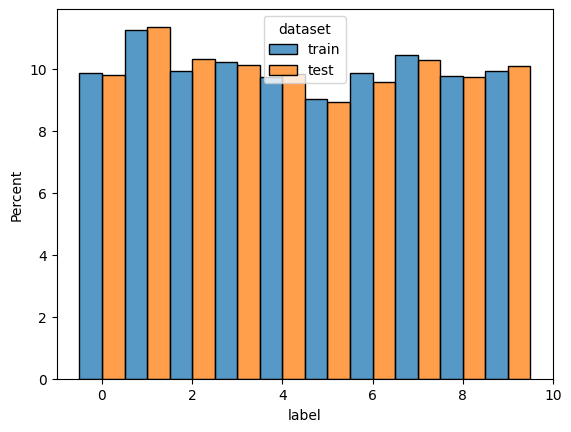

In [11]:
labels = pd.concat([train_labels, test_labels], axis=0)
sns.histplot(
    data=labels, 
    x="label", 
    hue="dataset", 
    multiple="dodge", 
    stat="percent",
    discrete=True,
    common_norm=False,
    )

In [12]:
print("Feature statistics")
print("Min:", train_features.min())
print("Max:", train_features.max())
print("Mean:", train_features.mean())
print("Std:", train_features.std())

Feature statistics
Min: tensor(-0.4242)
Max: tensor(2.8215)
Mean: tensor(-0.0001)
Std: tensor(1.0000)


The data is normalized correctly as we see.

## Visualize the pixel distributions in training set

Text(0.5, 1.0, 'Pixelwise median difference')

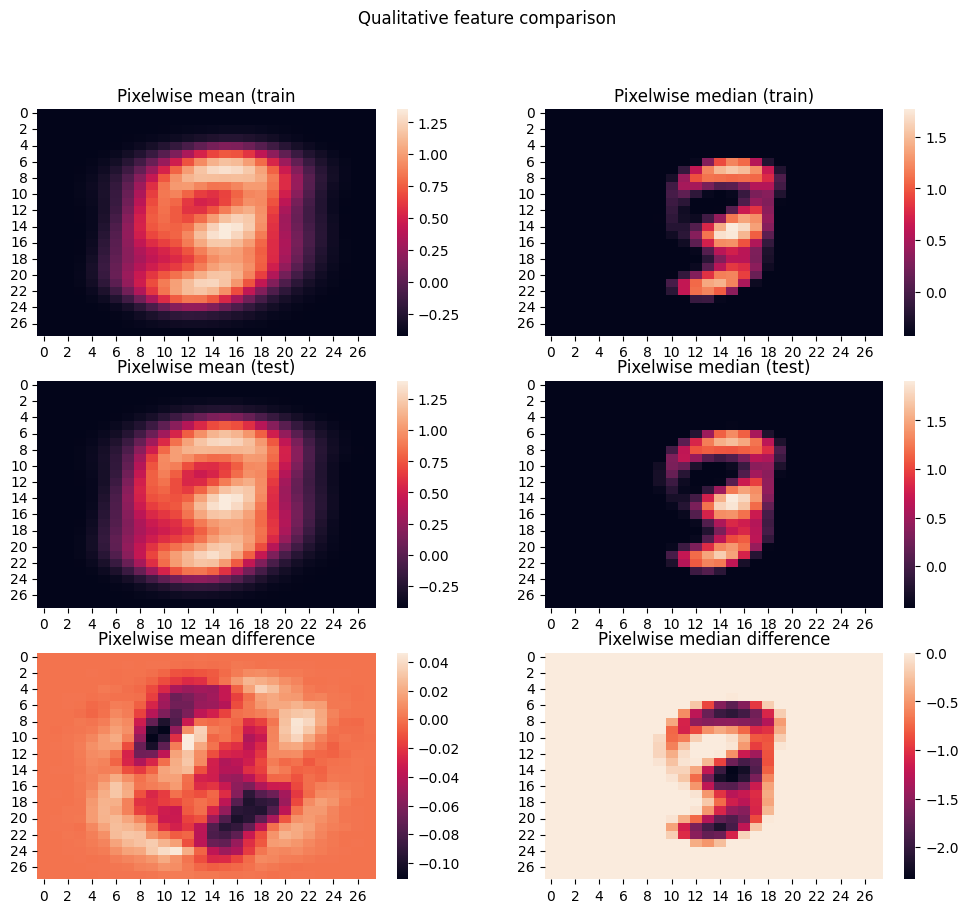

In [73]:
fig,axs = plt.subplots(3,2, figsize=(12,10))
plt.suptitle("Qualitative feature comparison")
sns.heatmap(train_features.mean(dim=0)[0], ax=axs[0,0])
axs[0, 0].set_title("Pixelwise mean (train")
sns.heatmap(np.median(train_features.detach().numpy(), axis=0)[0], ax=axs[0,1])
axs[0, 1].set_title("Pixelwise median (train)")
sns.heatmap(test_features.mean(dim=0)[0], ax=axs[1,0])
axs[1,0].set_title("Pixelwise mean (test)")
sns.heatmap(np.median((test_features).detach().numpy(), axis=0)[0], ax=axs[1,1])
axs[1,1].set_title("Pixelwise median (test)")
sns.heatmap(train_features.mean(dim=0)[0] - test_features.mean(dim=0)[0], ax=axs[2,0])
axs[2,0].set_title("Pixelwise mean difference")
sns.heatmap(np.median(train_features.detach().numpy()) - np.median((test_features).detach().numpy(), axis=0)[0], ax=axs[2,1])
axs[2,1].set_title("Pixelwise median difference")

## Feature engineering

For the more traditional models in comparison, the total number of input features 28x28 = 784 is significantly high, and PCA is used to reduce the features

In [13]:
from sklearn.decomposition import PCA

train_set_flat = train_features.flatten(start_dim=-2).squeeze()
test_set_flat = test_features.flatten(start_dim=-2).squeeze()
train_set_flat.shape, test_set_flat.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

### PCA Elbow Curve

Text(0, 0.5, 'Explained variance')

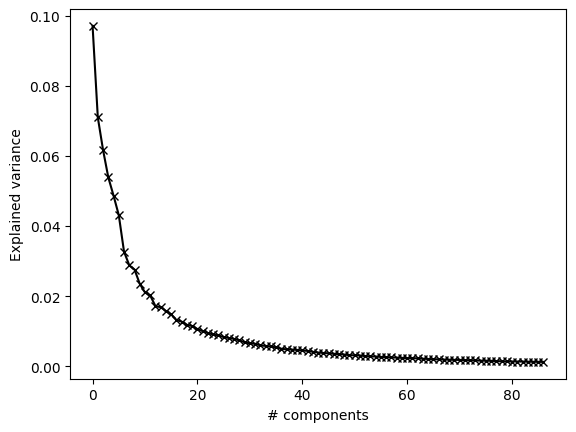

In [14]:
pca = PCA(0.9)
pca.fit(train_set_flat)
plt.plot(pca.explained_variance_ratio_, 'k-x')
plt.xlabel("# components")
plt.ylabel("Explained variance")

We can see that the curve begins to flatten out after 20 components, let's use that.

## Logistic Regression Model

Train accuracy 0.8750333333333333
Test accuracy 0.8806


<AxesSubplot: >

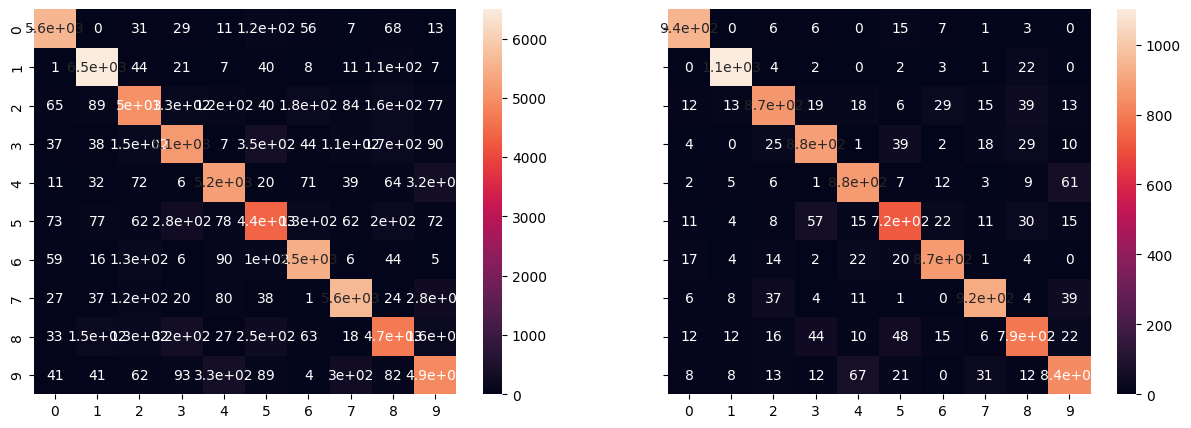

In [20]:
model = Pipeline(
    [
    ("pca", PCA(n_components=20)),
    ("reg", LogisticRegression(multi_class='multinomial', fit_intercept=True, max_iter=500)) # Cross-entropy loss
    ]
)
X_train = train_set_flat
y_train = train_labels["label"]

X_test = test_set_flat
y_test = test_labels["label"]

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Additional
print("Train accuracy", accuracy_score(y_train, y_pred_train))
print("Test accuracy", accuracy_score(y_test, y_pred_test))

fig, axs = plt.subplots(1,2, figsize=(15, 5), sharex=True, sharey=True)
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, ax=axs[0])
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, ax=axs[1])


## Decision Tree

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

def optimize_randomforest(X_train, y_train, random_grid, hparam_max_evals, metric, kfolds=5):
    # Inspiration from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    # First create the base model to tune
    rf = DecisionTreeClassifier()
    # Random search of parameters, using k-fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = hparam_max_evals, cv = kfolds, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    return rf_random
    

Note: As only the training data is used in the randomized hyperparameter search cross validation, it can be considered as using a separate train-val-test split, in which the train and validation sets are used to optimize the model and the test set is used only for testing to avoid overfitting by hyperparameter optimization.

In [201]:
# Number of features to consider at every split
max_features = np.linspace(0.33, 1.0, 5)
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

hparam_cv = optimize_randomforest(X_train, y_train,random_grid=random_grid, hparam_max_evals=10, metric="neg_accuracy_score", kfolds=3) # Due to computational limitation use 3-fold

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END max_depth=5, max_features=0.8325, min_samples_leaf=2, min_samples_split=2;, score=0.675 total time=   4.6s
[CV 2/5] END max_depth=5, max_features=0.8325, min_samples_leaf=2, min_samples_split=2;, score=0.679 total time=   4.9s
[CV 3/5] END max_depth=5, max_features=0.8325, min_samples_leaf=2, min_samples_split=2;, score=0.675 total time=   5.2s
[CV 4/5] END max_depth=5, max_features=0.8325, min_samples_leaf=2, min_samples_split=2;, score=0.649 total time=   5.4s
[CV 5/5] END max_depth=5, max_features=0.8325, min_samples_leaf=2, min_samples_split=2;, score=0.692 total time=   5.6s
[CV 1/5] END max_depth=7, max_features=0.665, min_samples_leaf=4, min_samples_split=10;, score=0.771 total time=   6.0s
[CV 2/5] END max_depth=7, max_features=0.665, min_samples_leaf=4, min_samples_split=10;, score=0.768 total time=   6.0s
[CV 3/5] END max_depth=7, max_features=0.665, min_samples_leaf=4, min_samples_split=10;, score=0.7

,mean_test_score,mean_fit_time
count,20.000,20.000
mean,0.797,8.481
std,0.058,5.967
min,0.674,2.769
25%,0.759,5.113
50%,0.803,6.584
75%,0.846,9.968
max,0.868,28.951


<AxesSubplot: xlabel='param_max_depth', ylabel='mean_test_score'>

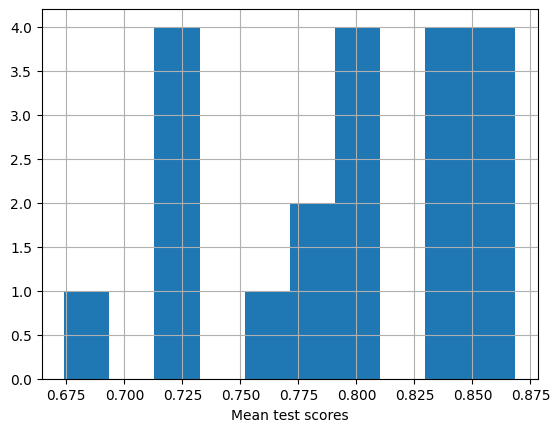

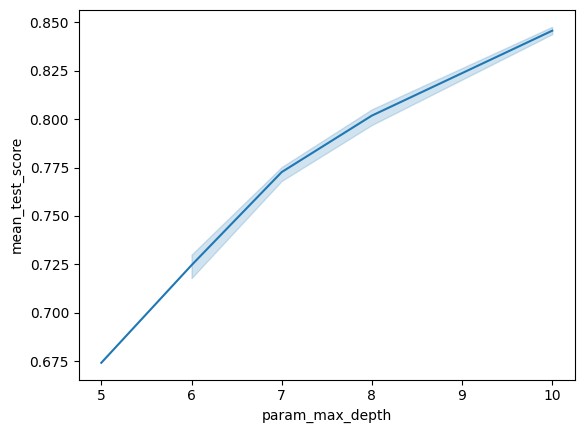

In [230]:
hparam_data = pd.DataFrame(hparam_cv.cv_results_)
display(hparam_data[["mean_test_score", "mean_fit_time"]].describe().round(3))
hparam_data["mean_test_score"].hist()
plt.xlabel("Mean test scores")
plt.figure()
sns.lineplot(data=hparam_data, x="param_max_depth", y="mean_test_score", estimator="mean")

We can see that the maximum value of max depth is limiting our performance. However as the parameter also increases fitting time, let us first apply the PCA.

In [214]:
pca = PCA(n_components=20)
hparam_cv_pca = optimize_randomforest(pca.fit_transform(X_train), y_train, random_grid=random_grid,hparam_max_evals=20, metric="neg_accuracy_score", kfolds=5) # Due to computational limitation use 3-fold

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 3/5] END max_depth=5, max_features=0.8325, min_samples_leaf=2, min_samples_split=2;, score=0.632 total time=   0.9s
[CV 1/5] END max_depth=5, max_features=0.8325, min_samples_leaf=2, min_samples_split=2;, score=0.598 total time=   0.9s
[CV 4/5] END max_depth=5, max_features=0.8325, min_samples_leaf=2, min_samples_split=2;, score=0.630 total time=   0.9s
[CV 5/5] END max_depth=5, max_features=0.8325, min_samples_leaf=2, min_samples_split=2;, score=0.623 total time=   0.9s
[CV 2/5] END max_depth=5, max_features=0.8325, min_samples_leaf=2, min_samples_split=2;, score=0.561 total time=   0.9s
[CV 1/5] END max_depth=7, max_features=0.665, min_samples_leaf=4, min_samples_split=10;, score=0.687 total time=   1.0s
[CV 2/5] END max_depth=7, max_features=0.665, min_samples_leaf=4, min_samples_split=10;, score=0.680 total time=   1.0s
[CV 4/5] END max_depth=7, max_features=0.665, min_samples_leaf=4, min_samples_split=10;, score=0.7

,mean_test_score,mean_fit_time
count,20.000,20.000
mean,0.797,8.481
std,0.058,5.967
min,0.674,2.769
25%,0.759,5.113
50%,0.803,6.584
75%,0.846,9.968
max,0.868,28.951


<AxesSubplot: xlabel='param_max_depth', ylabel='mean_test_score'>

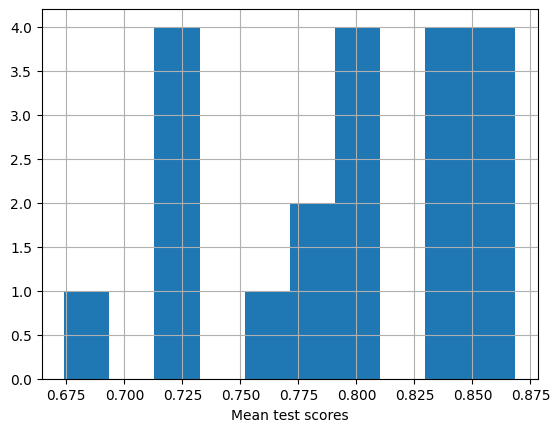

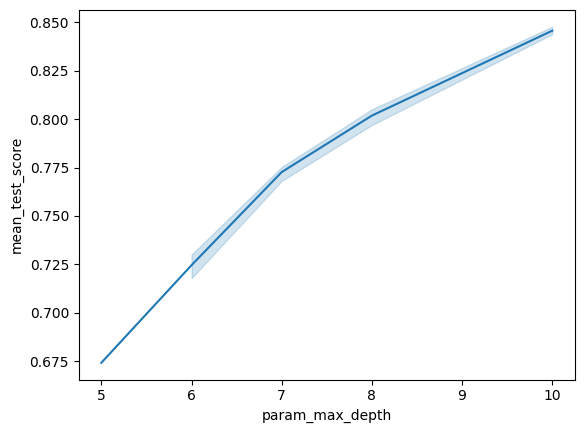

In [231]:
hparam_data_pca = pd.DataFrame(hparam_cv_pca.cv_results_)
display(hparam_data_pca[["mean_test_score", "mean_fit_time"]].describe().round(3))
hparam_data_pca["mean_test_score"].hist()
plt.xlabel("Mean test scores")
plt.figure()
sns.lineplot(data=hparam_data_pca, x="param_max_depth", y="mean_test_score", estimator="mean")

As we can see the performance didn't decrease even though the number of features is lower after the PCA. Let us increase the depth, since the training is significantly faster with the PCA.

In [21]:
# Number of features to consider at every split
max_features = np.linspace(0.33, 1.0, 5)
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 25, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

pca = PCA(n_components=20)
hparam_cv_pca = optimize_randomforest(pca.fit_transform(X_train), y_train, random_grid=random_grid,hparam_max_evals=20, metric="neg_accuracy_score", kfolds=5) # Due to computational limitation use 3-fold

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=10, max_features=0.8325, min_samples_leaf=2, min_samples_split=2; total time=   1.5s
[CV] END max_depth=10, max_features=0.8325, min_samples_leaf=2, min_samples_split=2; total time=   1.5s
[CV] END max_depth=10, max_features=0.8325, min_samples_leaf=2, min_samples_split=2; total time=   1.4s
[CV] END max_depth=10, max_features=0.8325, min_samples_leaf=2, min_samples_split=2; total time=   1.4s
[CV] END max_depth=10, max_features=0.8325, min_samples_leaf=2, min_samples_split=2; total time=   1.5s
[CV] END max_depth=17, max_features=0.665, min_samples_leaf=4, min_samples_split=10; total time=   1.6s
[CV] END max_depth=17, max_features=0.665, min_samples_leaf=4, min_samples_split=10; total time=   1.7s
[CV] END max_depth=17, max_features=0.665, min_samples_leaf=4, min_samples_split=10; total time=   1.7s
[CV] END max_depth=17, max_features=0.665, min_samples_leaf=4, min_samples_split=10; total time=   1.7s
[C

,mean_test_score,mean_fit_time
count,20.000,20.000
mean,0.829,1.722
std,0.014,0.804
min,0.784,0.806
25%,0.822,1.032
50%,0.833,1.502
75%,0.838,2.226
max,0.845,3.617


<AxesSubplot: xlabel='param_max_depth', ylabel='mean_test_score'>

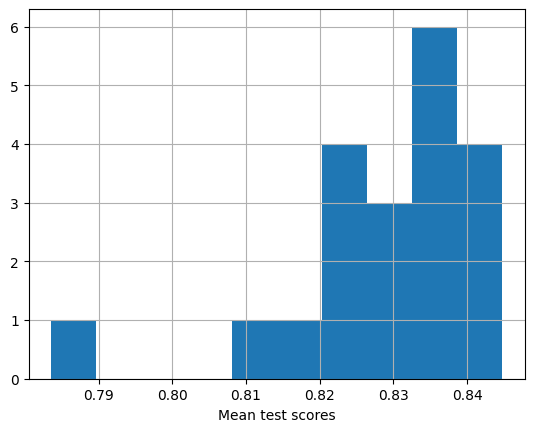

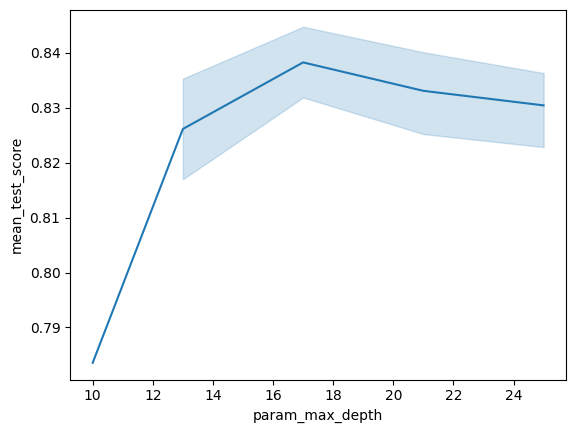

In [23]:
hparam_data_pca = pd.DataFrame(hparam_cv_pca.cv_results_)
display(hparam_data_pca[["mean_test_score", "mean_fit_time"]].describe().round(3))
hparam_data_pca["mean_test_score"].hist()
plt.xlabel("Mean test scores")
plt.figure()
sns.lineplot(data=hparam_data_pca, x="param_max_depth", y="mean_test_score", estimator="mean")

### Decision Tree Full Training Set test

Train accuracy 0.9422833333333334
Test accuracy 0.8501


<AxesSubplot: >

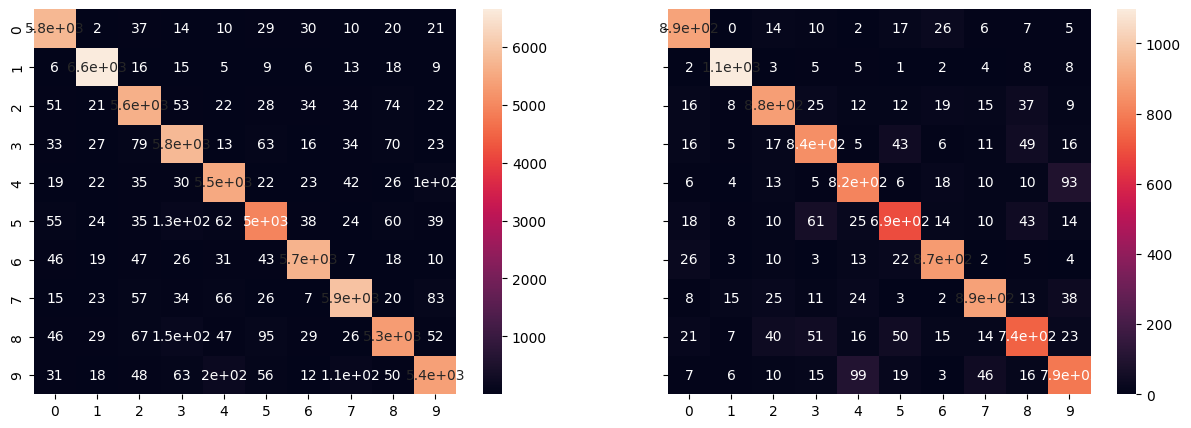

In [234]:
model_dt = Pipeline(
    [
    ("pca", PCA(n_components=20)),
    ("clf", DecisionTreeClassifier(**hparam_cv.best_params_))
    ]
)
model_dt.fit(X_train, y_train)
y_pred_train = model_dt.predict(X_train)
y_pred_test = model_dt.predict(X_test)

# Additional
print("Train accuracy", accuracy_score(y_train, y_pred_train))
print("Test accuracy", accuracy_score(y_test, y_pred_test))

fig, axs = plt.subplots(1,2, figsize=(15, 5), sharex=True, sharey=True)
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, ax=axs[0])
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, ax=axs[1])

## KMeans

Let us see if the classes are separable in the latent space

In [39]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
kmeans = KMeans(n_clusters=10) # 1 for each label

pipeline = Pipeline(
    [
    ("pca", pca),
    ("kmeans", kmeans)
    ]
    )

cluster_labels = pipeline.fit_predict(X_train)

pca_X = pca.fit_transform(X_train)

In [74]:
# Find the best permutation to match the cluster indices
from itertools import permutations
best_corr = 0

normal_order = list(range(10))

permuted_orders = permutations(normal_order)
permuted_orders[0]

TypeError: 'itertools.permutations' object is not subscriptable

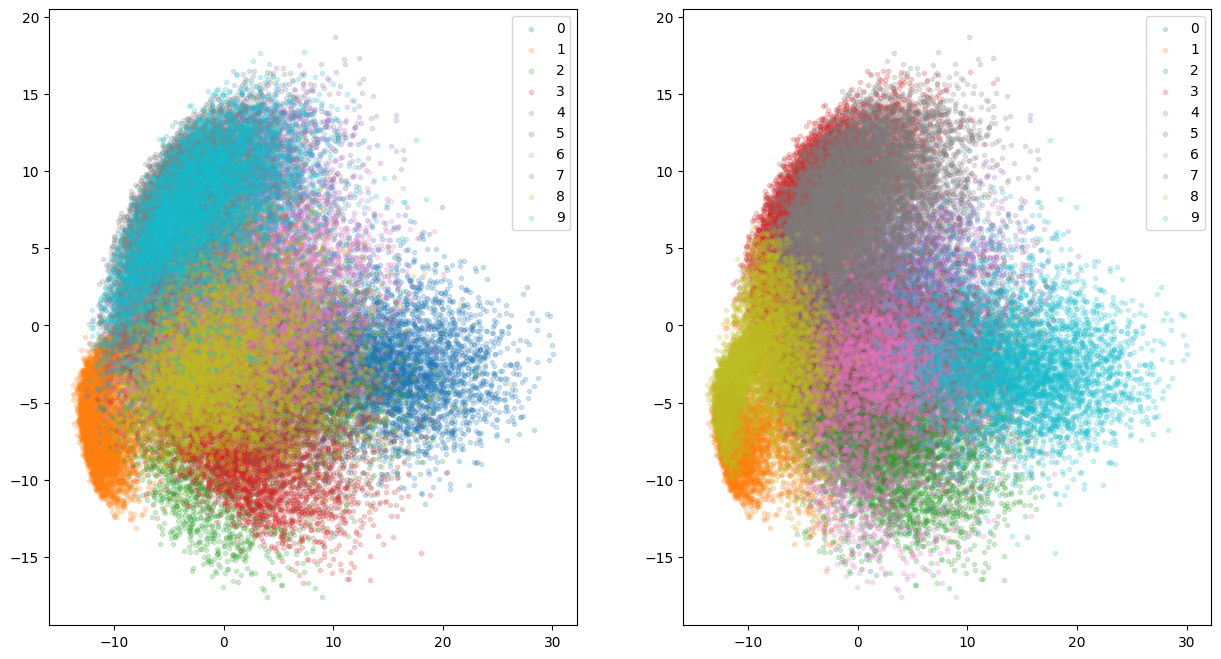

In [65]:
fig, axs = plt.subplots(1,2, figsize=(15,8))
for i in range(10):
    mask = y_train == i
    axs[0].scatter(pca_X[mask, 0], pca_X[mask,1], label=i, marker=".", alpha=.2)
    axs[0].legend()
for i in range(10):
    mask = cluster_labels == i
    axs[1].scatter(pca_X[mask, 0], pca_X[mask,1], label=i, marker=".", alpha=.2)
    axs[1].legend()

In [36]:
for i in range(0,10):
    print(pd.DataFrame({"cluster": (cluster_labels + i) % 10 , "label": y_train}).corr())

          cluster     label
cluster  1.000000 -0.086113
label   -0.086113  1.000000
          cluster     label
cluster  1.000000 -0.390222
label   -0.390222  1.000000
          cluster     label
cluster  1.000000 -0.315554
label   -0.315554  1.000000
          cluster     label
cluster  1.000000  0.079317
label    0.079317  1.000000
          cluster     label
cluster  1.000000 -0.050721
label   -0.050721  1.000000
          cluster     label
cluster  1.000000  0.223195
label    0.223195  1.000000
          cluster     label
cluster  1.000000  0.126052
label    0.126052  1.000000
          cluster     label
cluster  1.000000  0.113417
label    0.113417  1.000000
          cluster     label
cluster  1.000000  0.062616
label    0.062616  1.000000
          cluster     label
cluster  1.000000  0.212952
label    0.212952  1.000000
